# 네이버 검색어 트렌드

## # 01. 작업 준비

#### 패키지 참조

In [1]:
import requests
import json
from pandas import DataFrame, to_datetime

import sys
sys.path.append("../../")

import datetime as dt
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
import seaborn as sb

from helper import set_datetime_index, exp_time_data


## # 02. 네이버 검색어 트렌드 OpenAPI 연동

  - 접속에 필요한 정보 설정

API URL

In [2]:
API_URL = "https://openapi.naver.com/v1/datalab/search"

발급 받은 인증키

In [3]:
client_id = "ZpgN4whrqEh7K4rhkGjN"
client_secret = "aQwN4h5rFG"

접속 객체 생성

In [4]:
session = requests.Session()
session.headers.update({
    "X-Naver-Client-Id" : client_id,
    "X-Naver-Client-Secret" : client_secret
})

##### HTTP 접속 방법 종류

  - HTTP GET 방식인 경우
    > session.get(API_URL, params={"a": 100, "b": 200})
  - HTTP POST 방식인 경우
    > session.post(API_URL, data={"a": 100, "b": 200})
  - HTTP POST 방식이면서 파라미터를 JSON으로 구성하는 경우(body data 전송)
    > session.post(API_URL, data=json.dumps({"a": 100, "b": 200}))

전달할 검색어 구성

In [11]:
data = {
    "startDate": "2020-01-01",   # 2016년 1월 1일부터 조회 시작 가능
    "endDate": "2023-07-31",
    "timeUnit": "date",         # date: 일간, week: 주간, month: 월간
    "keywordGroups": [
        {
            "groupName": "건담",  # 검색주제
            "keywords": ["반다이", "프라모델", "애니", "건담베이스"]   # 주제와 관련된 검색어
        }
    ]
}

데이터 요청하기

In [12]:
r = session.post(API_URL, data = json.dumps(data))

if r.status_code != 200:
    msg = "[%d Error] %s 에러가 발생함" % (r.status_code, r.reason)
    raise Exception(msg)

r.encoding = "utf-8"
mydict = json.loads(r.text)
mydict

{'startDate': '2020-01-01',
 'endDate': '2023-07-31',
 'timeUnit': 'date',
 'results': [{'title': '건담',
   'keywords': ['반다이', '프라모델', '애니', '건담베이스'],
   'data': [{'period': '2020-01-01', 'ratio': 20.5513},
    {'period': '2020-01-02', 'ratio': 18.23665},
    {'period': '2020-01-03', 'ratio': 17.63344},
    {'period': '2020-01-04', 'ratio': 18.81882},
    {'period': '2020-01-05', 'ratio': 17.67552},
    {'period': '2020-01-06', 'ratio': 17.24065},
    {'period': '2020-01-07', 'ratio': 17.21961},
    {'period': '2020-01-08', 'ratio': 17.17051},
    {'period': '2020-01-09', 'ratio': 17.33885},
    {'period': '2020-01-10', 'ratio': 15.96408},
    {'period': '2020-01-11', 'ratio': 17.10738},
    {'period': '2020-01-12', 'ratio': 18.81882},
    {'period': '2020-01-13', 'ratio': 18.46812},
    {'period': '2020-01-14', 'ratio': 17.17752},
    {'period': '2020-01-15', 'ratio': 16.9671},
    {'period': '2020-01-16', 'ratio': 18.11741},
    {'period': '2020-01-17', 'ratio': 18.74167},
    {'peri

가져온 결과를 데이터프레임으로 변환

In [13]:
df = DataFrame(mydict['results'][0]['data'])
df

,period,ratio
0,2020-01-01,20.55130
1,2020-01-02,18.23665
2,2020-01-03,17.63344
3,2020-01-04,18.81882
4,2020-01-05,17.67552
...,...,...
1303,2023-07-27,15.05225
1304,2023-07-28,17.78775
1305,2023-07-29,18.28575
1306,2023-07-30,18.11741


## # 03. 연동 결과에 대한 시계열 분석

데이터 타입 확인

In [14]:
df.dtypes

period     object
ratio     float64
dtype: object

날짜 컬럼에 대한 형변환 및 인덱스 설정

In [15]:
df['period'] = to_datetime(df['period'])
df2 = set_datetime_index(df, 'period')
df2

,ratio
2020-01-01,20.55130
2020-01-02,18.23665
2020-01-03,17.63344
2020-01-04,18.81882
2020-01-05,17.67552
...,...
2023-07-27,15.05225
2023-07-28,17.78775
2023-07-29,18.28575
2023-07-30,18.11741


helper에 구현된 기능을 활용하여 데이터 검정

결측치 수: 0


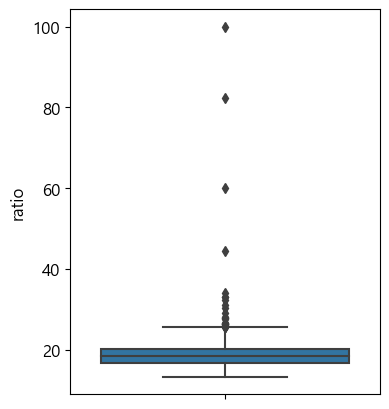

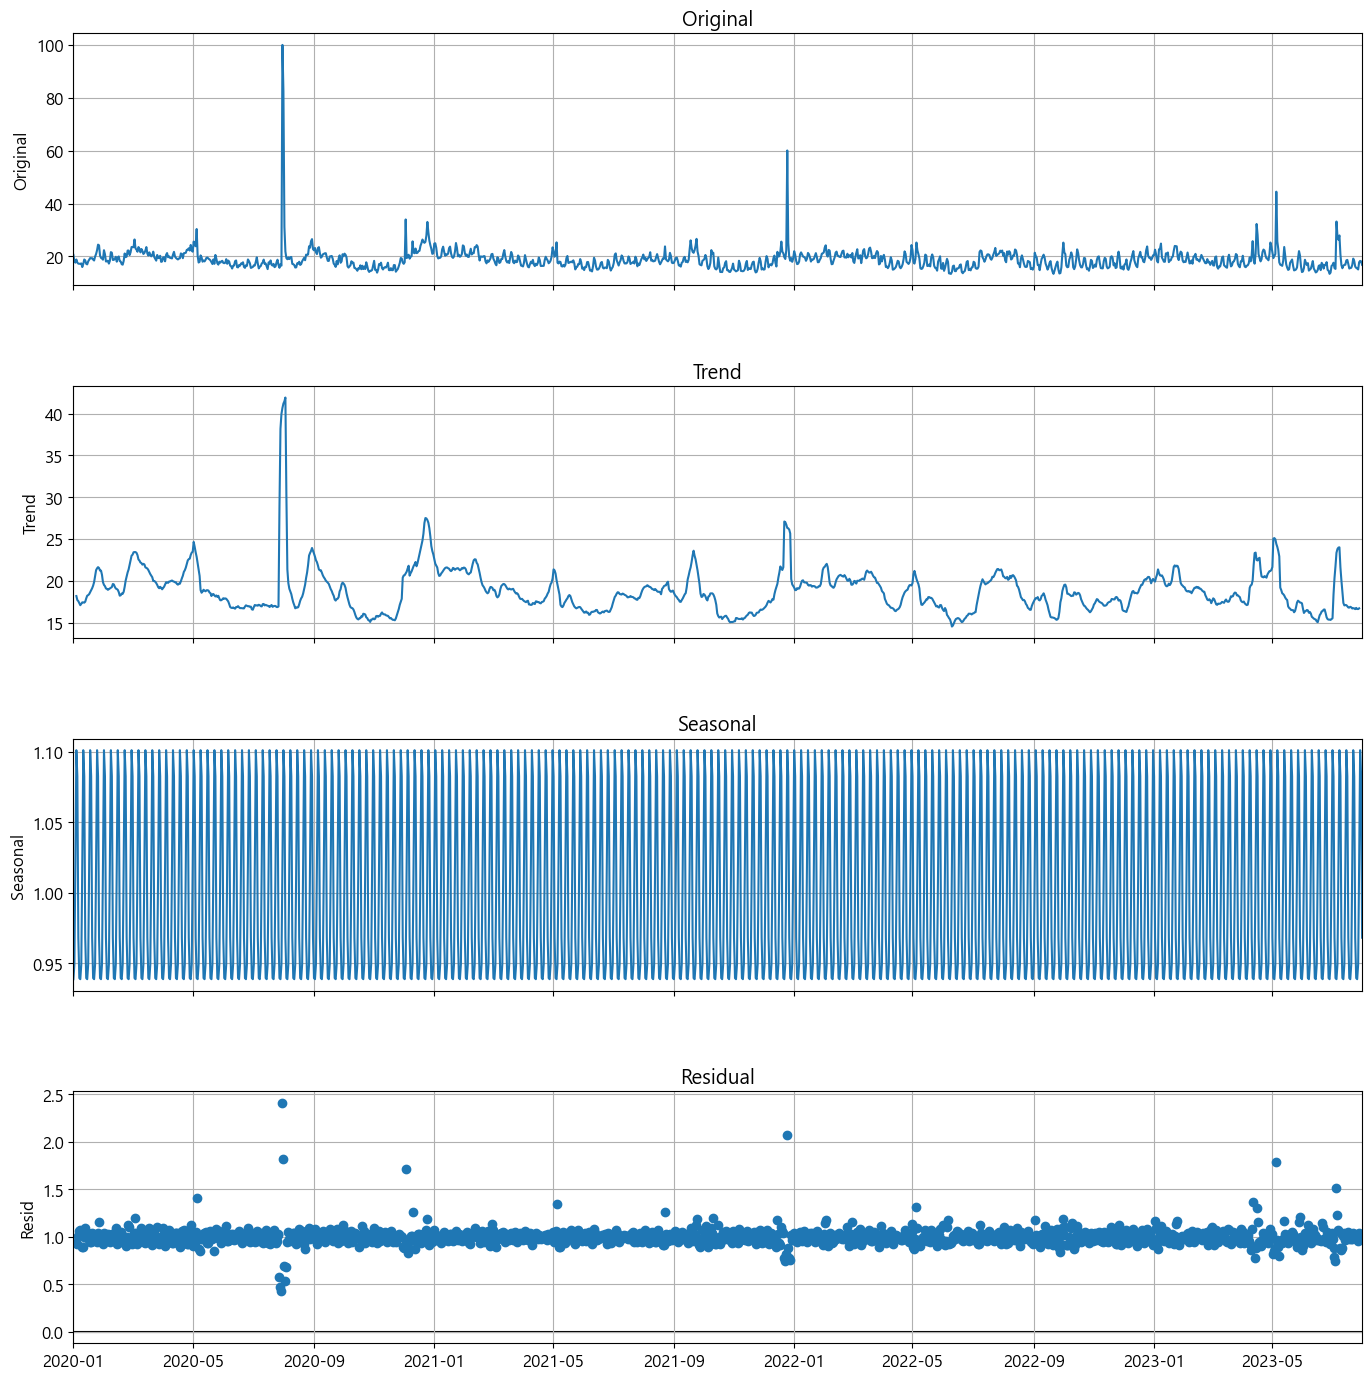

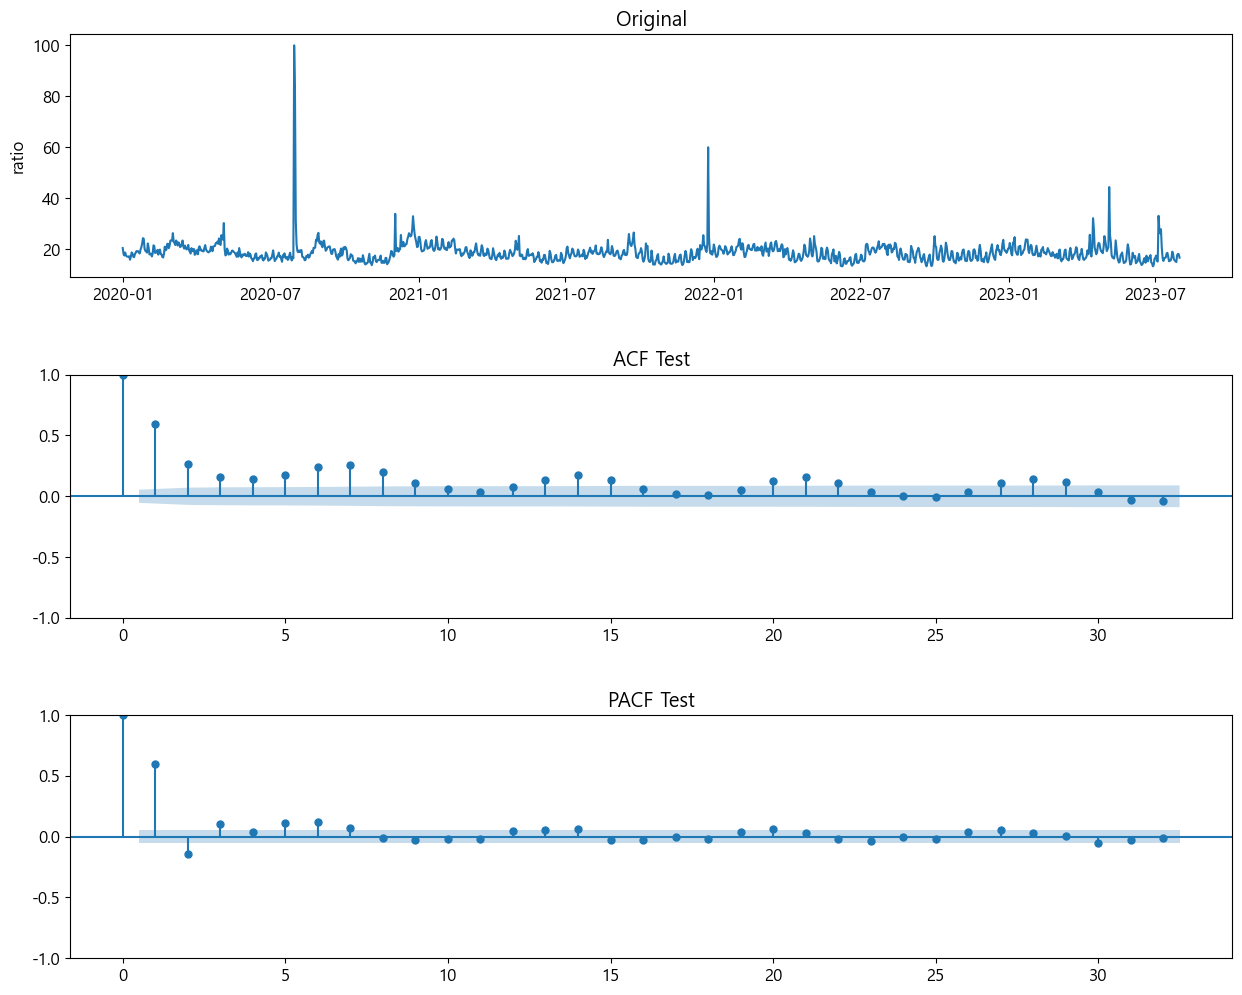

=========== 원본 데이터 ===========
+------------------------------------+-------------+
| ADF Test                           |             |
|------------------------------------+-------------|
| 검정통계량(ADF Statistic)          |    -8.47486 |
| 유의수준(p-value)                  | 1.44458e-13 |
| 최적차수(num of lags)              |           6 |
| 관측치 개수(num of observations)   |        1301 |
| 기각값(Critical Values) 1%         |    -3.43539 |
| 기각값(Critical Values) 5%         |    -2.86376 |
| 기각값(Critical Values) 10%        |    -2.56795 |
| 데이터 정상성 여부(0=Flase,1=True) |           1 |
+------------------------------------+-------------+


In [16]:
exp_time_data(df2, 'ratio', "m")

ARIMA 분석 수행

  - 분석 모델 구성

In [19]:
model = ARIMA(df2['ratio'], order = (1,0,0), seasonal_order = (1,1,0,7))
fit = model.fit()
print(fit.summary())

                                    SARIMAX Results                                    
Dep. Variable:                           ratio   No. Observations:                 1308
Model:             ARIMA(1, 0, 0)x(1, 1, 0, 7)   Log Likelihood               -3600.877
Date:                         Tue, 08 Aug 2023   AIC                           7207.753
Time:                                 11:57:09   BIC                           7223.266
Sample:                             01-01-2020   HQIC                          7213.574
                                  - 07-31-2023                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5431      0.006     91.346      0.000       0.531       0.555
ar.S.L7       -0.4852      0.003   -164.557      0.000     

학습 결과에 대한 예측값 확인

In [20]:
fv = fit.fittedvalues
fv.head()

2020-01-01    0.000000
2020-01-02    0.000298
2020-01-03    0.000417
2020-01-04    0.000457
2020-01-05    0.000468
Freq: D, dtype: float64

향후 30일 간의 예상치 생성

In [21]:
fc = fit.forecast(30)
fc.head()

2023-08-01    15.625380
2023-08-02    15.543375
2023-08-03    15.390156
2023-08-04    17.295984
2023-08-05    18.716078
Freq: D, Name: predicted_mean, dtype: float64

시각화

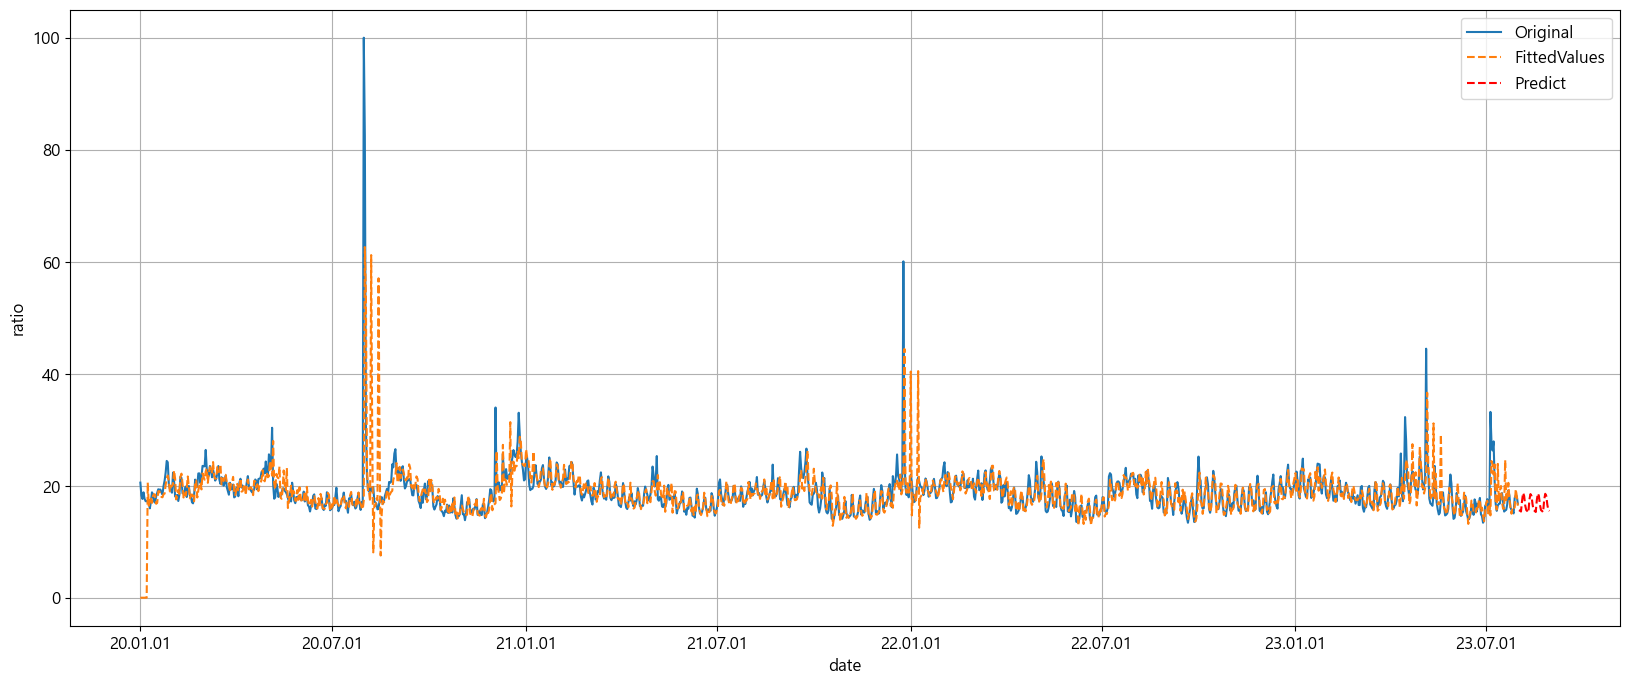

In [22]:
plt.figure(figsize=(20,8))

sb.lineplot(data=df2, x=df2.index, y='ratio', label='Original')
sb.lineplot(x=fv.index, y=fv.values, label='FittedValues', linestyle='--')
sb.lineplot(x=fc.index, y=fc.values, label='Predict', linestyle='--', color='red')

plt.xlabel('date')
plt.ylabel('ratio')
plt.legend()

monthyearFmt = mdates.DateFormatter('%y.%m.%d')
plt.gca().xaxis.set_major_formatter(monthyearFmt)

plt.grid()
plt.show()
plt.close()